# How to create a multi-witness transaction

A multi-witness transaction, allow you to spend funds from different wallets that your control or not.   
For spending the funds from different wallets, you just have to provide a signature of the transanction of each addresses where the UTXOs is locked. 

### Get the UTXO from the addresses you want to used for the payment 

In [28]:
%%bash
# Djessy wallet 1
cardano-cli query utxo \
--address $(cat /users/$(whoami)/testnet/priv/wallet/Djessy/djessy.addr) \
--testnet-magic 1

# Drake wallet 2
cardano-cli query utxo \
--address $(cat /users/$(whoami)/testnet/priv/wallet/Djessy-Wallet2/djessy.addr) \
--testnet-magic 1

                           TxHash                                 TxIx        Amount
--------------------------------------------------------------------------------------
08b99aaa95c752e2a2c128e0ef65ae1aa492aef8103f71a01a0faee39c256879     0        7699334124 lovelace + TxOutDatumNone
c370cb076dc5893f548a8acf42fd507f4c21d667c036602e9092ca38f5fafbc5     0        200000000 lovelace + TxOutDatumNone
                           TxHash                                 TxIx        Amount
--------------------------------------------------------------------------------------
08b99aaa95c752e2a2c128e0ef65ae1aa492aef8103f71a01a0faee39c256879     1        2000000000 lovelace + TxOutDatumNone


## 1) Build the transaction using the command build

In this transaction, we will send funds to an other address using the UTXOs from two different wallets that we control (where you own the signing key).  

You can make the same transaction with a wallet that you don't control, you just have to build the transaction, send it to the person who own the UTXOs used as input so he can signed it. Where you have all the signature, you just have to assemble it and submit it to the node.

In [38]:
%%bash
UTXO_IN1=08b99aaa95c752e2a2c128e0ef65ae1aa492aef8103f71a01a0faee39c256879#0
UTXO_IN2=c370cb076dc5893f548a8acf42fd507f4c21d667c036602e9092ca38f5fafbc5#0
UTXO_IN3=08b99aaa95c752e2a2c128e0ef65ae1aa492aef8103f71a01a0faee39c256879#1
CHANGE_ADDR=$(cat /users/$(whoami)/testnet/priv/wallet/Lola/lola.addr)

# Build the transaction
cardano-cli transaction build \
--witness-override 2 \
--tx-in $UTXO_IN1 \
--tx-in $UTXO_IN2 \
--tx-in $UTXO_IN3 \
--change-address $CHANGE_ADDR \
--testnet-magic 1 \
--out-file tx-files/tx-one.raw

# Sign the transaction with the private key of the address 1 (Djessy wallet 1)
cardano-cli transaction witness \
--signing-key-file /users/$(whoami)/testnet/priv/wallet/Djessy-Wallet1/djessy.addr.skey \
--tx-body-file tx-files/tx-one.raw \
--out-file tx-files/djessyW1.witness

# Sign the transaction with the private key of the address 2 (Djessy wallet 2
cardano-cli transaction witness \
--signing-key-file /users/$(whoami)/testnet/priv/wallet/Djessy-Wallet2/djessy.addr.skey \
--tx-body-file tx-files/tx-one.raw \
--out-file tx-files/djessyW2.witness

# Assemble the transaction
cardano-cli transaction assemble \
--tx-body-file tx-files/tx-one.raw \
--witness-file tx-files/djessyW1.witness \
--witness-file tx-files/djessyW2.witness \
--out-file tx-files/tx-one.signed

Estimated transaction fee: Lovelace 171529


### Flow chart of the transaction

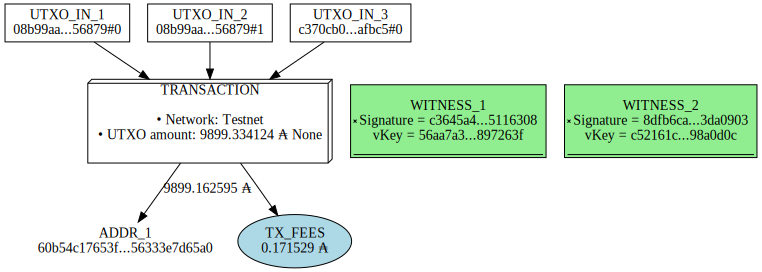

In [39]:
from IPython.display import SVG
from cardano_py_tools import transaction as tx
tx.vizualisation(txFile="tx-files/tx-one.signed", saveTo="tx-files/tx-one.svg")
SVG("tx-files/tx-one.svg")

### Submit the transaction

In [42]:
%%bash
# Submit the transaction
cardano-cli transaction submit \
--tx-file tx-files/tx-one.signed \
--testnet-magic 1

Transaction successfully submitted.


### Get the UTXO from the addresses you want to used for the payment 

In [45]:
%%bash
# Djessy wallet 1
cardano-cli query utxo \
--address $(cat /users/$(whoami)/testnet/priv/wallet/Lola/lola.addr) \
--testnet-magic 1

# Drake wallet 2
cardano-cli query utxo \
--address $(cat /users/$(whoami)/testnet/priv/wallet/Drake/drake.addr) \
--testnet-magic 1

                           TxHash                                 TxIx        Amount
--------------------------------------------------------------------------------------
0055ed89ccd6a31b0a01b67a3d554ae9699b85ce12d3d37d9ce49ee02f0a4c67     0        9899162595 lovelace + TxOutDatumNone
                           TxHash                                 TxIx        Amount
--------------------------------------------------------------------------------------
0be38e65bec5eebde5ca3308a75e5c8adcd1b184534b445c984185d7d6f9aee5     1        100000000 lovelace + TxOutDatumNone
3e0f2493e7556968b9534e439111c08da761ac52783c7188b4b944068c0662ee     1        100000000 lovelace + TxOutDatumNone
8d4f02739f9f921e7d50cd7765527242a1ca5bd37dc479a550af99463290d89f     1        100000000 lovelace + TxOutDatumNone
c370cb076dc5893f548a8acf42fd507f4c21d667c036602e9092ca38f5fafbc5     1        9799824379 lovelace + TxOutDatumNone


## 2) Build the transaction using the command build-raw

In this transaction we will spend funds from one wallet that we control(Lola wallet) and the wallet of someone else (Drake wallet).  
The transaction will be build off-chain using the command `cardano-cli transaction build-raw`.

In [61]:
%%bash
UTXO_IN1=0055ed89ccd6a31b0a01b67a3d554ae9699b85ce12d3d37d9ce49ee02f0a4c67#0
UTXO_IN2=3e0f2493e7556968b9534e439111c08da761ac52783c7188b4b944068c0662ee#1
RECEVEIR_ADDR=$(cat /users/$(whoami)/testnet/priv/wallet/Djessy/djessy.addr)
AMOUNT_TO_SENT=$((9899162595 + 100000000)) 

# Build the draft transaction
cardano-cli transaction build-raw \
--fee 0 \
--tx-in $UTXO_IN1 \
--tx-in $UTXO_IN2 \
--tx-out $RECEVEIR_ADDR+0 \
--out-file tx-files/tx-two.draft

# Save the protocol parameters
cardano-cli query protocol-parameters \
--testnet-magic 1 \
--out-file tx-files/protocol-params.json

# Calculate the fees
FEE=$(echo $(cardano-cli transaction calculate-min-fee \
--protocol-params-file tx-files/protocol-params.json \
--tx-body-file tx-files/tx-two.draft \
--tx-in-count 2 \
--tx-out-count 1 \
--witness-count 2) | cut -d ' ' -f1)

# Build the transaction
cardano-cli transaction build-raw \
--fee $FEE \
--tx-in $UTXO_IN1 \
--tx-in $UTXO_IN2 \
--tx-out $RECEVEIR_ADDR+$(($AMOUNT_TO_SENT - $FEE)) \
--out-file tx-files/tx-two.raw

# Sign the transaction with the Lola wallet private key
cardano-cli transaction witness \
--signing-key-file /users/$(whoami)/testnet/priv/wallet/Lola/lola.addr.skey \
--tx-body-file tx-files/tx-two.raw \
--out-file tx-files/djessyW1.witness

# Here, in the real life, you have to know the other person (Drake wallet). 
# You have to send him the transaction for him to signed it and send it back the signed file.
cardano-cli transaction witness \
--signing-key-file /users/$(whoami)/testnet/priv/wallet/Drake/drake.addr.skey \
--tx-body-file tx-files/tx-two.raw \
--out-file tx-files/djessyW2.witness

# Assemble the transaction 
cardano-cli transaction assemble \
--tx-body-file tx-files/tx-two.raw \
--witness-file tx-files/djessyW1.witness \
--witness-file tx-files/djessyW2.witness \
--out-file tx-files/tx-two.signed

### Flow chart of the transaction

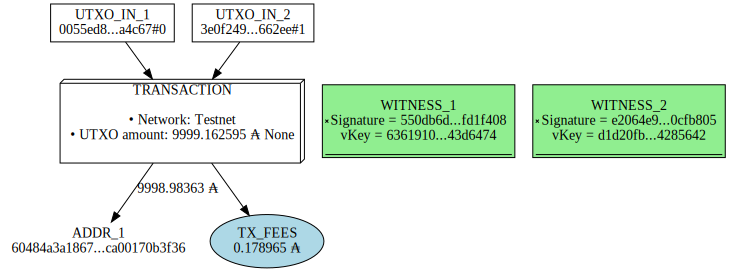

In [62]:
from IPython.display import SVG
from cardano_py_tools import transaction as tx
tx.vizualisation(txFile="tx-files/tx-two.signed", saveTo="tx-files/tx-two.svg")
SVG("tx-files/tx-two.svg")

### Submit the transaction

In [63]:
%%bash
# Submit the transaction
cardano-cli transaction submit \
--tx-file tx-files/tx-two.signed \
--testnet-magic 1

Transaction successfully submitted.


In [64]:
%%bash
# Djessy wallet 1
cardano-cli query utxo \
--address $(cat /users/$(whoami)/testnet/priv/wallet/Djessy/djessy.addr) \
--testnet-magic 1

                           TxHash                                 TxIx        Amount
--------------------------------------------------------------------------------------
b74048f802c6001998cc544583d9473cd7e58adb79eac49f4da000e03c342a8b     0        9998983630 lovelace + TxOutDatumNone


In [65]:
!jupytext --to markdown how-to-create-a-multi-witness-tx.ipynb

[jupytext] Reading how-to-create-a-multi-witness-tx.ipynb in format ipynb
[jupytext] Writing how-to-create-a-multi-witness-tx.md
